In [17]:
# libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, HTML
display(HTML(""))
import scienceplots
plt.style.use(['science', 'no-latex'])
import folium
from folium import plugins
from folium.plugins import HeatMap

In [2]:
# import
la = pd.read_csv("prepared_data.csv", parse_dates=["start_time","end_time"],low_memory=False)

In [41]:
start_count = la['start_station_name'].value_counts()
end_count = la['end_station_name'].value_counts()

In [42]:
start_station_df = start_count.to_frame().rename(columns={'start_station_name': 'count'})
start_station_df['start_station_name'] = start_station_df.index
start_station_df.head(3)

,count,start_station_name
7th & Flower,14186,7th & Flower
Main & 1st,13172,Main & 1st
Union Station West Portal,10975,Union Station West Portal


In [5]:
end_station_df = end_count.to_frame().rename(columns={'end_station_name': 'count'})
end_station_df['end_station_name'] = end_station_df.index
end_station_df.head(3)

,count,end_station_name
7th & Flower,14892,7th & Flower
Union Station West Portal,12164,Union Station West Portal
Main & 1st,11535,Main & 1st


<BarContainer object of 50 artists>

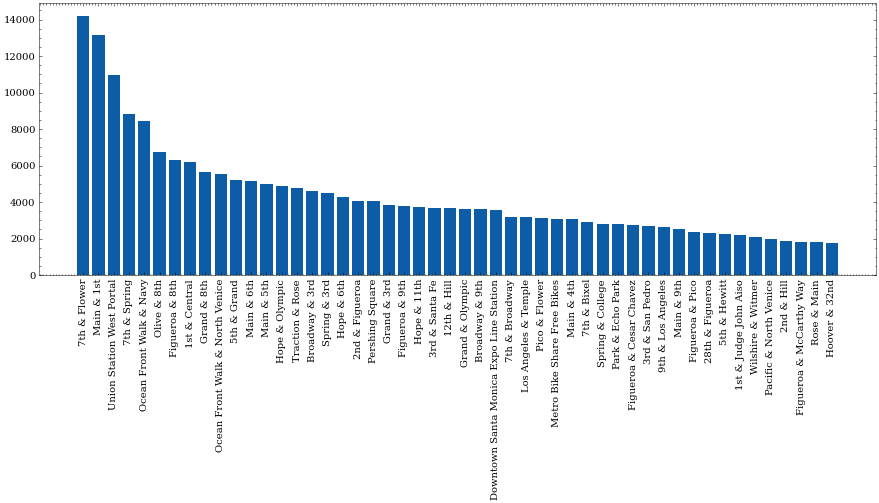

In [6]:
fig, ax = plt.subplots(figsize=[15,5])
plt.setp(ax.xaxis.get_majorticklabels(),rotation=90,fontsize=10)
ax.bar(start_station_df['start_station_name'].iloc[:50], start_station_df['count'].iloc[:50])

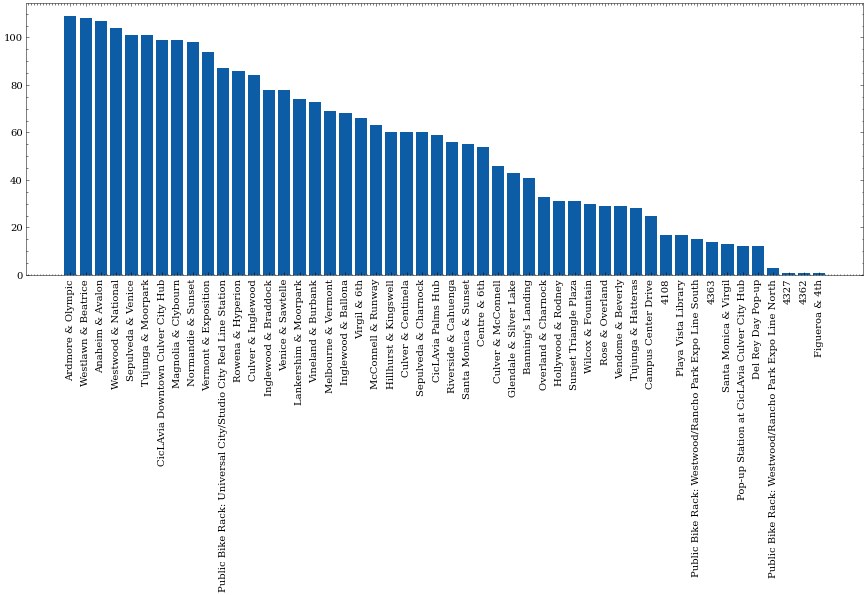

In [7]:
fig, ax = plt.subplots(figsize=[15,5])
plt.setp(ax.xaxis.get_majorticklabels(),rotation=90,fontsize=10)
ax.bar(start_station_df['start_station_name'].iloc[-50:], start_station_df['count'].iloc[-50:])
plt.show()

In [8]:
la["route"] = (la["start_station_name"] +" to "+ la["end_station_name"])

In [9]:
la.head(3)

,Unnamed: 0,start_time,end_time,start_station_id,end_station_id,bike_id,user_type,start_station_name,end_station_name,duration,route
0,0,2019-01-01 00:07:00,2019-01-01 00:14:00,3046,3051,06468,Walk-up,2nd & Hill,7th & Broadway,7.0,2nd & Hill to 7th & Broadway
1,1,2019-01-01 00:08:00,2019-01-01 00:14:00,3046,3051,12311,Walk-up,2nd & Hill,7th & Broadway,6.0,2nd & Hill to 7th & Broadway
2,2,2019-01-01 00:18:00,2019-01-01 00:50:00,3030,3075,05992,Walk-up,Main & 1st,Broadway & 9th,32.0,Main & 1st to Broadway & 9th


In [10]:
route = la['route'].value_counts()

In [11]:
route_df = route.to_frame().rename(columns={'route': 'count'})
route_df['route'] = route_df.index
route_df.head(3)

,count,route
Main & 1st to Union Station West Portal,5135,Main & 1st to Union Station West Portal
Union Station West Portal to Main & 1st,4397,Union Station West Portal to Main & 1st
Ocean Front Walk & Navy to Ocean Front Walk & Navy,4364,Ocean Front Walk & Navy to Ocean Front Walk & ...


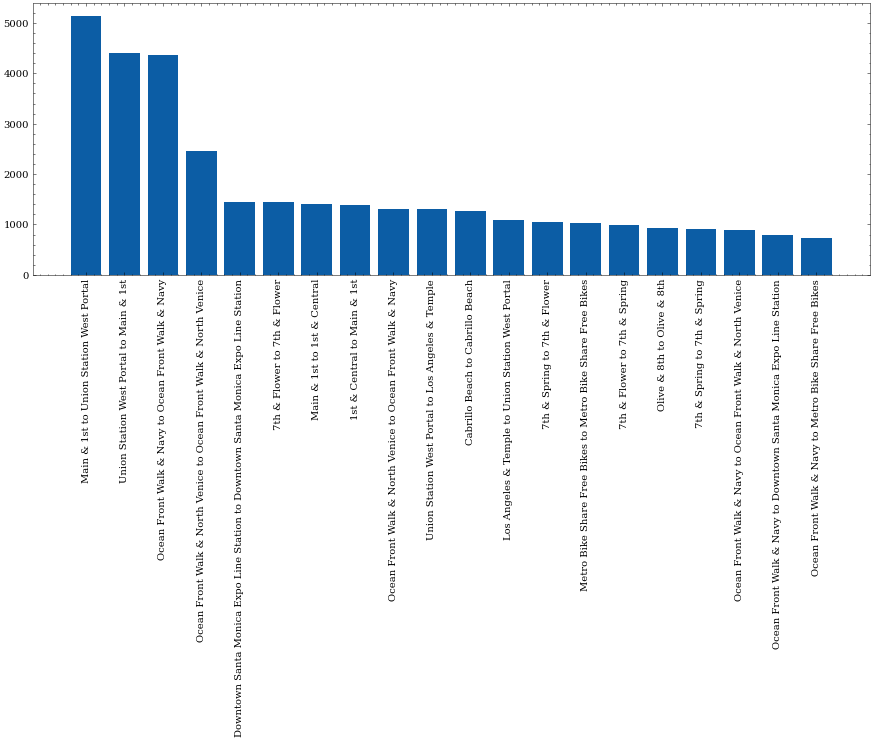

In [12]:
fig, ax = plt.subplots(figsize=[15,5])
plt.setp(ax.xaxis.get_majorticklabels(),rotation=90,fontsize=10)
ax.bar(route_df['route'].iloc[:20], route_df['count'].iloc[:20])
plt.show()

In [45]:
# new data set with station information 
# https://gbfs.bcycle.com/bcycle_lametro/station_information.json
coordinates = pd.read_csv("station_information.csv")
# drop unnecessary columns
coordinates = coordinates.drop(columns=['ttl', 'data__stations__rental_uris__ios','data__stations__rental_uris__android','version','last_updated'])
coordinates.head(3)

,data__stations__lon,data__stations__lat,data__stations___bcycle_station_type,data__stations__region_id,data__stations__address,data__stations__name,data__stations__station_id
0,-118.25854,34.04850,Kiosk and Station,bcycle_lametro_region_1,Reinstalled 6/15,7th & Flower,bcycle_lametro_3005
1,-118.25667,34.04554,Kiosk and Station,bcycle_lametro_region_1,729 S Olive Street,Olive & 8th,bcycle_lametro_3006
2,-118.25459,34.05048,Kiosk and Station,bcycle_lametro_region_1,557 S 5th Street,5th & Grand,bcycle_lametro_3007


In [46]:
# adding coordinates to stations
coordinates["ziped_coords"] = list(zip(coordinates["data__stations__lat"],coordinates["data__stations__lon"]))
start_station_df = start_station_df.merge(coordinates["ziped_coords"].to_frame(),how = "left",left_on=start_station_df["start_station_name"],right_on=coordinates["data__stations__name"])
start_station_df = start_station_df.drop(columns=["key_0"])

# dropping stations without location data
start_station_df = start_station_df.dropna(axis=0)
start_station_df.head(3)

,count,start_station_name,ziped_coords
0,14186,7th & Flower,"(34.0485, -118.25854)"
1,13172,Main & 1st,"(34.05194, -118.24353)"
2,10975,Union Station West Portal,"(34.05661, -118.23721)"


In [47]:
# stations; size --> logarithmic number of started tours
log_map = folium.Map(location=(34.052235, -118.243683),tiles='OpenStreetMap',zoom_start=11, control_scale=True, max_zoom=20)
# drawing maps and dots
for index, row in start_station_df.iterrows():
    folium.CircleMarker(radius=np.power(np.log(row["count"])/4,1.5), location=row["ziped_coords"], popup=row["start_station_name"], color="red", fill_color="red",weight=2).add_to(log_map)

log_map